# GLM: 1st-level Analysis

The objective in this example is to model the timecurse of each voxel. This will allow us to answer question regarding to the voxel response to different stimuli. 

We will model the activation at each voxel $y$ as a weighed sum of explanatory variables $x_{i}$ 
and error term ${\epsilon}$

$${y} = {\beta}_{0} + \sum \limits _{i=1} ^{N} x_{i}{\beta}_{i} + {\epsilon} $$

or in matrix notation

$$ y = {\beta} X + {\epsilon} $$

which can be solved with Ordinary Least Squares regression.

The paramters ${\beta}$ represnt the contribution of each variable to the voxel activation.

The error terms are asumed to be independent and identically distributed.

![Design matrix](https://mri-q.com/uploads/3/4/5/7/34572113/9355842_orig.jpg)

The matrix  𝑋  is also called design matrix.It is up to the resercher which factors to include in the design matrix. The design matirx conatins factors that a related to the hypothesis the resercher want to answer. Furthemore, sometimes in it are also included factors that are not related to the hypothesis, but are know sources of variability (nuisance factors).

Now lets take a look how we take into account the delayed bold respose.
The hemdynamic respose function might look something like this:


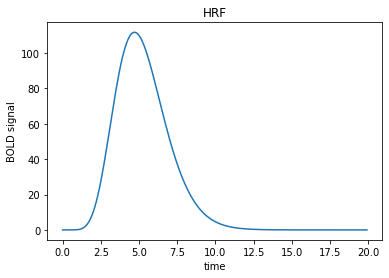

In [1]:
import numpy as np 
import matplotlib.pyplot as plt


def hrf(t):
    return t ** 8.6 * np.exp(-t / 0.547)

hrf_times = np.arange(0, 20, 0.1)
hrf_signal = hrf(hrf_times)
plt.plot(hrf_times, hrf_signal)
plt.xlabel('time')
plt.ylabel('BOLD signal')
_ = plt.title('HRF')

In the design Often we want to include variabales, that indicate presense or absense of a stimuli.
Let's say we had the 3 stimly during the timecouse

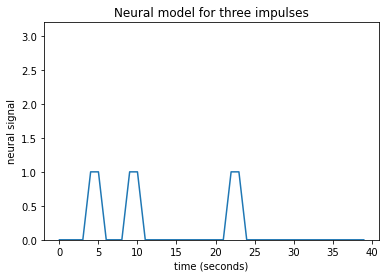

In [2]:
n_time_points = 40

times = np.arange(0, n_time_points)  

neural_signal = np.zeros(n_time_points)
neural_signal[4:6] = 1  # A 3 second event
neural_signal[9:11] = 1
neural_signal[22:24] = 1

plt.plot(times, neural_signal)
plt.xlabel('time (seconds)')
plt.ylabel('neural signal')
plt.ylim(0, 3.2)
_ = plt.title('Neural model for three impulses')

Next we have to convolve signal with our hrf function

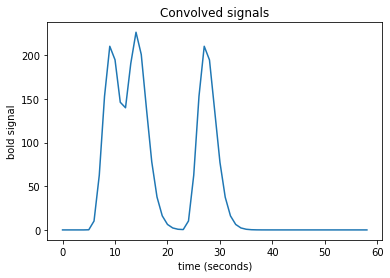

In [3]:
hrf_times = np.arange(20)
hrf_signal = hrf(hrf_times)
bold_signal = np.convolve(neural_signal, hrf_signal)

tailed_respose_times = np.arange(n_time_points + hrf_times.shape[0] - 1)
plt.plot(tailed_respose_times, bold_signal)
plt.xlabel('time (seconds)')
plt.ylabel('bold signal')
_ = plt.title('Convolved signals')

After that we can fit our fMRI data to the design Matix and use GLM to for hypotesis testing.
We can evaluate whether a given factor $i$ has a considarable contribution by its coeficnent ${\beta}_{i}$.
With t-test we can evaluate whether ${\beta}_{i}$ > 0. We can also test hypotesis of the form ${\beta}_{i}$ > ${\beta}_{j}$.

The general form of the hypthesis tests which forms a **contrast** is:
$$\sum \limits _{i=1} ^{N} c_{i}{\beta}_{i} > 0 $$

Typical values for $c$ are 1 and -1.
Typicaly contrasts are express as:$ [c_{1}, c_{2}, ..., c_{N}]$.

For example the contrast [1, 0] tests ${\beta}_{1}$ > 0.

This contrasts form a t-statisitcs (Recall that coeficents in OLS regression follow t-distribution). 

We can combine several contrasts and form F-statics. In the contexts of fMRI the F-tests help us answer questions like "Is effect A or effect B or effect C, or any combinaton of them, significantly non-zero?".

Combining the test results from all voxels we get statistical map of brain activity.
Now that the theory out of our way we can see how it is done in Nipype.


# 1st Leval Analysis in Nipype

 We will use the preprocessed files we got and run 1st-level analysis (individual analysis) for each subject. We will perform the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

In [4]:
import pandas as pd
import os

from nilearn import plotting
%matplotlib inline


from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
from utils import list_files

200731-13:31:32,369 nipype.utils WARNING:
	 A newer version (1.5.0) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


In [5]:
# specify paths
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
# Repetition time(TR) of functional images
TR = 2.5

## Prepare design matrix
Let's take a look how the stimuli onset and duration look like.This information is store in a ``tsv`` file. This file wil help us build the design matrix.

The three different conditions in the **fingerfootlips** task are:
- **finger**
- **foot**
- **lips**

In [6]:
trialinfo = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
trialinfo.head()

,onset,duration,weight,trial_type
0,10,15.0,1,Finger
1,40,15.0,1,Foot
2,70,15.0,1,Lips
3,100,15.0,1,Finger
4,130,15.0,1,Foot


In [7]:
def subjectinfo(subject_id):
    import pandas as pd
    from nipype.interfaces.base import Bunch

    
    trialinfo = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10)) # subtracting 10s due to removing of 4 dummy scans
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

## Initiate Nodes

In [8]:
# SpecifyModel - Generates SPM-specific Model
#Setup
#https://nipype.readthedocs.io/en/latest/api/generated/nipype.algorithms.modelgen.html#specifymodel
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
#https://www.fil.ion.ucl.ac.uk/spm/doc/manual.pdf#page=59
#hrf- Name of basis function(canonical)
#'derivs': [1, 0]-Time derivatives : Time and Dispersion

#model_serial_correlations-serial correlations using an autoregressive estimator (order 1)

level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
#https://www.fil.ion.ucl.ac.uk/spm/doc/manual.pdf#page=69

level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

## Specify contrasts
We are gona perform several T tests and one F test. Recall the general form of the hypothesis are

$$\sum \limits _{i=1} ^{N} c_{i}{\beta}_{i} > 0 $$

In [9]:
# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
# contrast =  [<contrast_name>, <test>, <condition_names>, <[c1, c2, c3]>]
cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', condition_names, [1, 0, 0]]
cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
cont05 = ['Foot > others',  'T', condition_names, [-0.5, 1, -0.5]]
cont06 = ['activation',     'F', [cont02, cont03, cont04]]
# fill a contrast 'Finger > others'
contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06]

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [10]:
#Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {
        'func': 'datasink/preproc/sub-{subject_id}/task-{task_id}/ssub-{subject_id}_ses-test_task-{task_id}_bold.nii',
        'mc_param': 'datasink/preproc/sub-{subject_id}/task-{task_id}/sub-{subject_id}_ses-test_task-{task_id}_bold.par',
        'outliers': 'datasink/preproc/sub-{subject_id}/task-{task_id}/art.sub-{subject_id}_ses-test_task-{task_id}_bold_outliers.txt'
    }
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'fingerfootlips'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and **connect** the interface nodes and the I/O stream to each other.

In [11]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = f'{experiment_dir}/{working_dir}'

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

## Visualize the workflow

200731-13:31:32,978 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


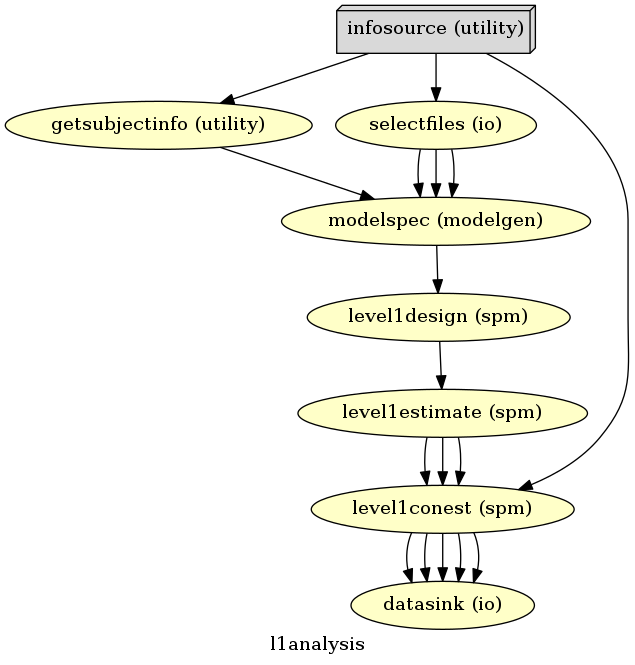

In [12]:
# Save the 1st-level analysis graph as png
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=f'{l1analysis.base_dir}/l1analysis/graph.png')

200731-13:31:33,539 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.png (graph2use=flat, simple_form=True).


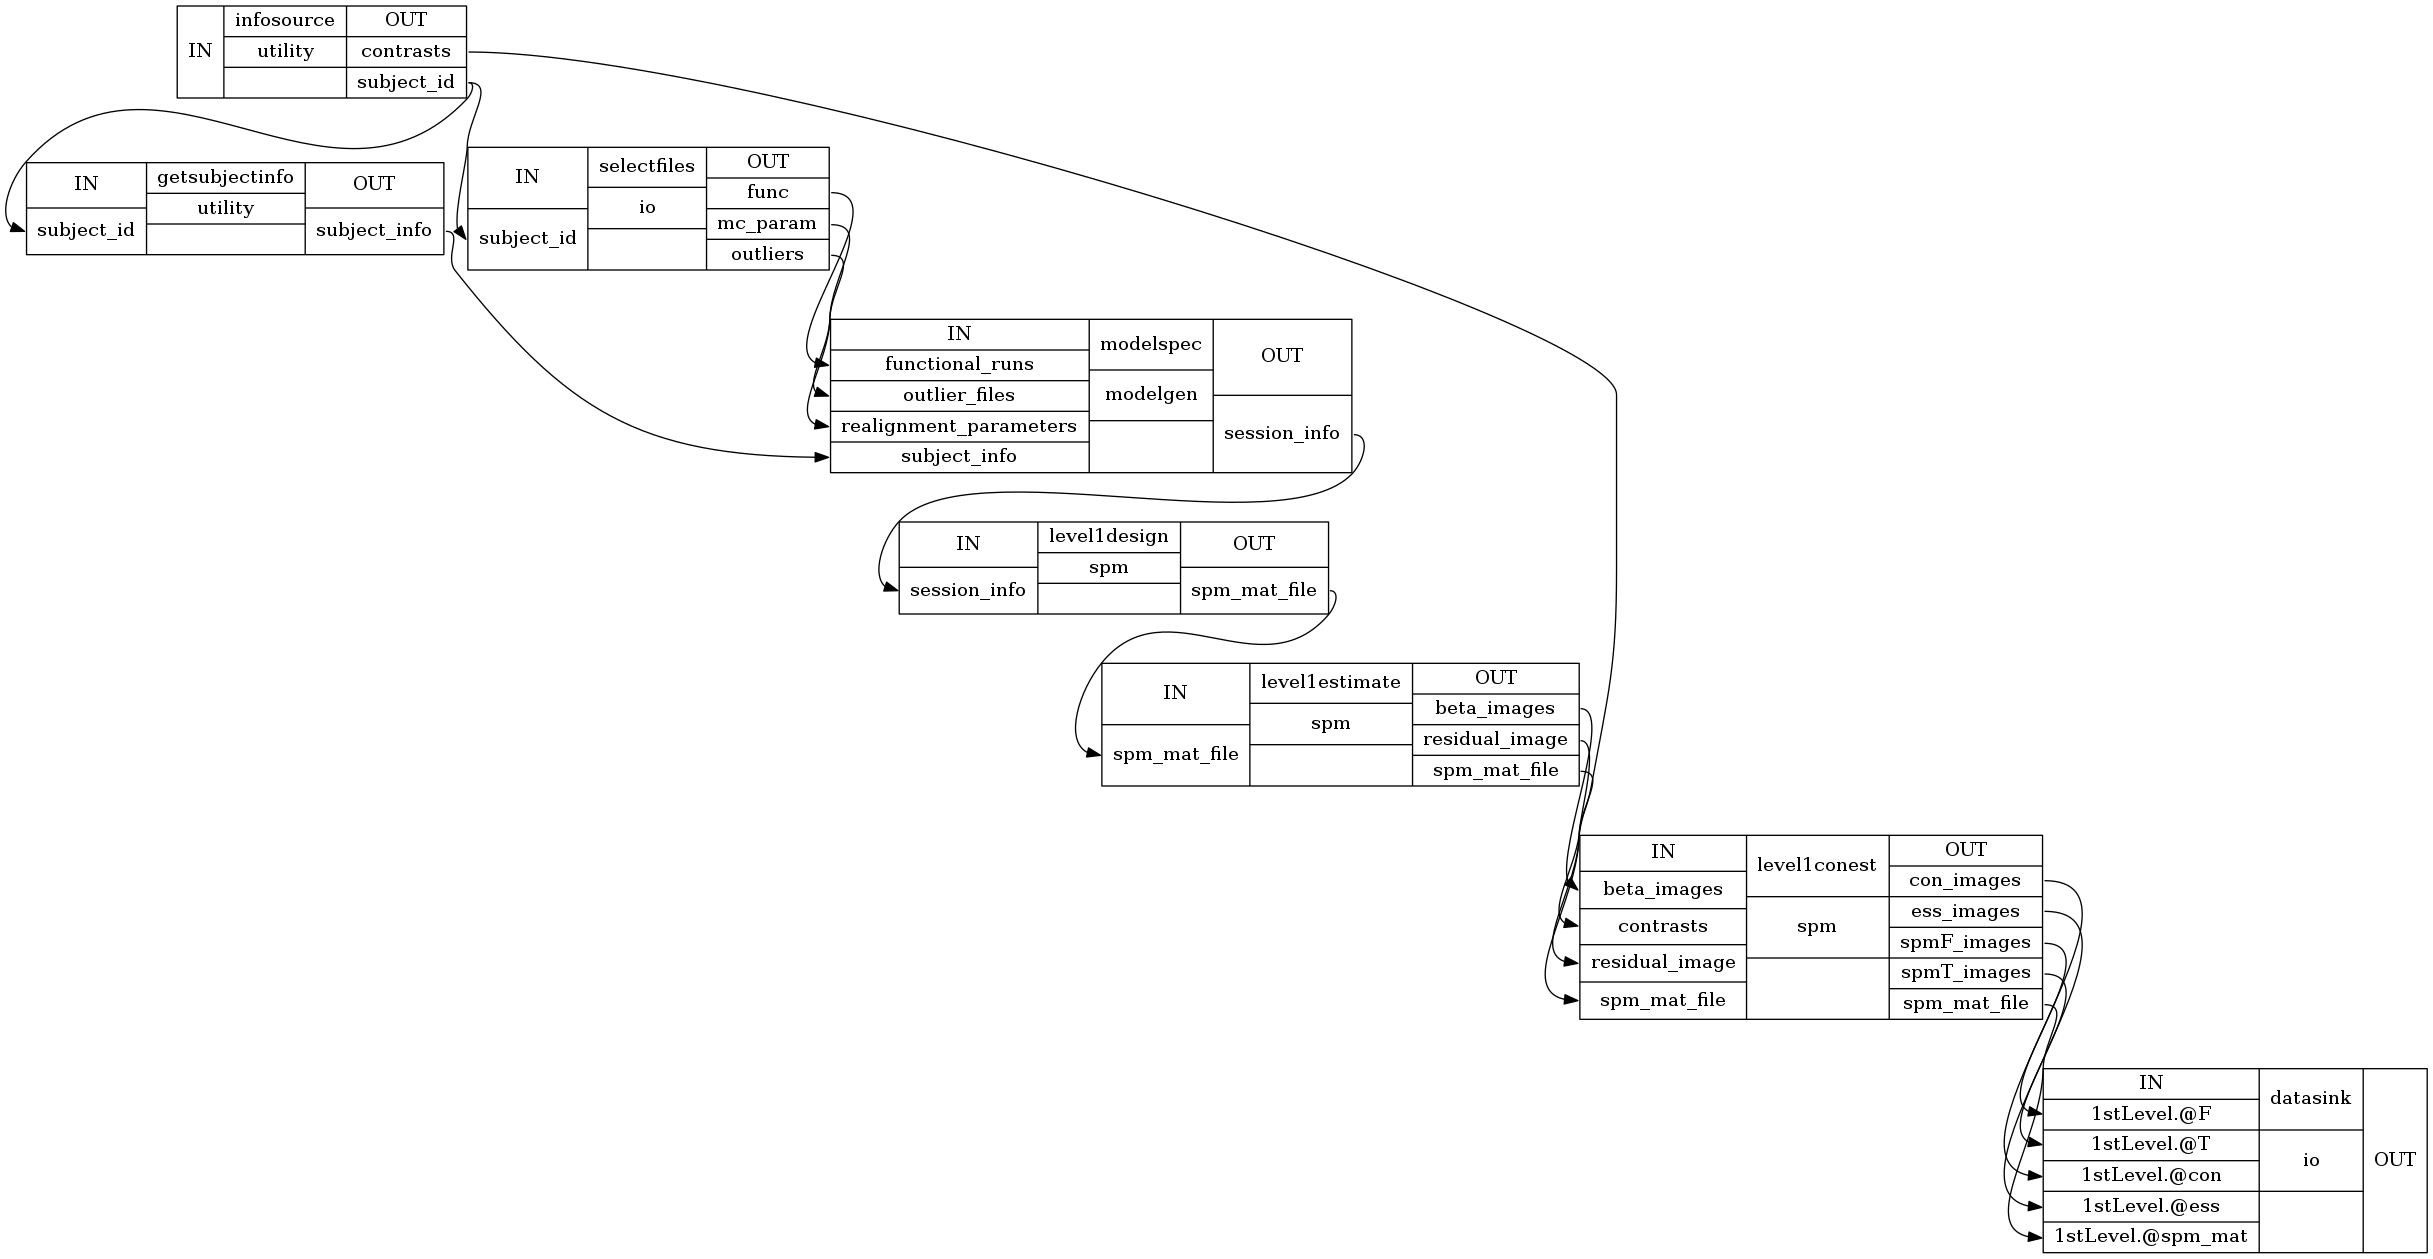

In [13]:
# show detailed workflow
l1analysis.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=f'{l1analysis.base_dir}/l1analysis/graph_detailed.png')

##  Run the Workflow

Run the 1st-level analysis workflow.

In [14]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

200731-13:31:33,588 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
200731-13:31:33,658 nipype.workflow INFO:
	 Running in parallel.
200731-13:31:33,665 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 20 jobs ready. Free memory (GB): 226.64/226.64, Free processors: 4/4.
200731-13:31:33,752 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_09/getsubjectinfo".200731-13:31:33,752 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_10/selectfiles".

200731-13:31:33,763 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")200731-13:31:33,764 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")

200731-13:31:33,750 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_s

200731-13:31:48,497 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
200731-13:31:48,501 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
200731-13:31:49,679 nipype.workflow INFO:
	 [Job 3] Completed (l1analysis.level1design).
200731-13:31:49,681 nipype.workflow INFO:
	 [Job 10] Completed (l1analysis.level1design).
200731-13:31:49,685 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 14 jobs ready. Free memory (GB): 226.24/226.64, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
200731-13:31:49,744 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/output/workingdir/l1analysis/_subject_id_10/level1estimate".200731-13:31:49,744 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/output/workingdir/l1analysis/_subject_id_09/level1estimate".

200731-13:31:49,755 nipype.workflow INFO:
	 [Node]

	 sub: /output/datasink/1stLevel/_subject_id_09/SPM.mat -> /output/datasink/1stLevel/sub-09/SPM.mat200731-13:32:13,789 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")

200731-13:32:13,790 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_09/spmT_0001.nii -> /output/datasink/1stLevel/sub-09/spmT_0001.nii
200731-13:32:13,791 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_10/SPM.mat -> /output/datasink/1stLevel/sub-10/SPM.mat200731-13:32:13,792 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_09/spmT_0002.nii -> /output/datasink/1stLevel/sub-09/spmT_0002.nii

200731-13:32:13,793 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_10/spmT_0001.nii -> /output/datasink/1stLevel/sub-10/spmT_0001.nii200731-13:32:13,794 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_09/spmT_0003.nii -> /output/datasink/1stLevel/sub-09/spmT_0003.nii

200731-13:32:13,795 nipype.interf

	 sub: /output/datasink/1stLevel/_subject_id_08/con_0005.nii -> /output/datasink/1stLevel/sub-08/con_0005.nii
200731-13:32:15,818 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_08/ess_0006.nii -> /output/datasink/1stLevel/sub-08/ess_0006.nii
200731-13:32:15,820 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_08/spmF_0006.nii -> /output/datasink/1stLevel/sub-08/spmF_0006.nii
200731-13:32:15,822 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_08/ess_0006.nii -> /output/datasink/1stLevel/sub-08/ess_0006.nii
200731-13:32:15,827 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
200731-13:32:17,709 nipype.workflow INFO:
	 [Job 20] Completed (l1analysis.datasink).
200731-13:32:17,712 nipype.workflow INFO:
	 [Job 28] Completed (l1analysis.getsubjectinfo).
200731-13:32:17,714 nipype.workflow INFO:
	 [Job 29] Completed (l1analysis.selectfiles).
200731-13:32:17,719 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 11

200731-13:32:23,784 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_04/modelspec".200731-13:32:23,784 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_03/selectfiles".

200731-13:32:23,791 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
200731-13:32:23,796 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
200731-13:32:23,799 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
200731-13:32:23,821 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
200731-13:32:25,717 nipype.workflow INFO:
	 [Job 44] Completed (l1analysis.modelspec).
200731-13:32:25,720 nipype.workflow INFO:
	 [Job 50] Completed (l1analysis.selectfiles).
200731-13:32:25,724 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 6 jobs ready. Free memory (GB): 226.24/226.64, Free p

200731-13:32:48,697 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
200731-13:32:49,739 nipype.workflow INFO:
	 [Job 46] Completed (l1analysis.level1estimate).
200731-13:32:49,744 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 5 jobs ready. Free memory (GB): 226.04/226.64, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
200731-13:32:49,810 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_04/level1conest".
200731-13:32:49,833 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
200731-13:32:50,315 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
200731-13:32:51,741 nipype.workflow INFO:
	 [Job 53] Completed (l1analysis.level1estimate).
200731-13:32:51,745 nipype.w

	 [Node] Finished "l1analysis.datasink".
200731-13:32:57,747 nipype.workflow INFO:
	 [Job 41] Completed (l1analysis.datasink).
200731-13:32:57,750 nipype.workflow INFO:
	 [Job 56] Completed (l1analysis.getsubjectinfo).
200731-13:32:57,754 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 3 jobs ready. Free memory (GB): 226.24/226.64, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
200731-13:32:57,813 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_01/getsubjectinfo".200731-13:32:57,813 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_02/selectfiles".

200731-13:32:57,817 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
200731-13:32:57,820 nipype.workflow INFO:
	 [Node] Running "selectf

	 sub: /output/datasink/1stLevel/_subject_id_03/con_0005.nii -> /output/datasink/1stLevel/sub-03/con_0005.nii
200731-13:33:01,879 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_03/ess_0006.nii -> /output/datasink/1stLevel/sub-03/ess_0006.nii
200731-13:33:01,880 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".200731-13:33:01,881 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_03/spmF_0006.nii -> /output/datasink/1stLevel/sub-03/spmF_0006.nii200731-13:33:01,881 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")


200731-13:33:01,883 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_03/ess_0006.nii -> /output/datasink/1stLevel/sub-03/ess_0006.nii
200731-13:33:01,888 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
200731-13:33:03,753 nipype.workflow INFO:
	 [Job 55] Completed (l1analysis.datasink).
200731-13:33:03,756 nipype.workflow INFO:
	 [Job 65] Comp

	 [Node] Finished "l1analysis.datasink".
200731-13:33:37,263 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
200731-13:33:37,788 nipype.workflow INFO:
	 [Job 68] Completed (l1analysis.level1conest).
200731-13:33:37,791 nipype.workflow INFO:
	 [Job 62] Completed (l1analysis.datasink).
200731-13:33:37,795 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 226.64/226.64, Free processors: 4/4.
200731-13:33:37,857 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_01/datasink".
200731-13:33:37,868 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
200731-13:33:37,870 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_01/SPM.mat -> /output/datasink/1stLevel/sub-01/SPM.mat
200731-13:33:37,872 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_01/spmT_0001.nii -> /output/datasink/1stLevel/sub-01/spmT_0001.nii
2007

In [15]:
#Crashs information is stored in .pklz files
# In case of a crash use the following command
#!nipypecli crash <Last generated .pklz file>

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should one image for each subject and contrast (``con_*.nii`` for T-contrasts and ``ess_*.nii`` for F-contrasts)

In [16]:
!tree /output/datasink/1stLevel

/output/datasink/1stLevel
├── sub-01
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── con_0004.nii
│   ├── con_0005.nii
│   ├── ess_0006.nii
│   ├── spmF_0006.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   ├── spmT_0004.nii
│   └── spmT_0005.nii
├── sub-02
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── con_0004.nii
│   ├── con_0005.nii
│   ├── ess_0006.nii
│   ├── spmF_0006.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   ├── spmT_0004.nii
│   └── spmT_0005.nii
├── sub-03
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── con_0004.nii
│   ├── con_0005.nii
│   ├── ess_0006.nii
│   ├── spmF_0006.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   ├── spmT_0004.nii
│   └── spmT_0005.nii
├── sub-04
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── con_0004.nii
│   ├── con_0005.nii
│  

## Visualize results

Let's look at the contrasts of one subject that we've just computed. 

In [17]:
from nilearn.plotting import plot_stat_map

#Reminder the tests were 
test_to_number = {
    1: 'average',
    2: 'Finger',
    3: 'Foot',
    4: 'Lips',
    5: 'Foot > others',
    6: 'activation'
    }
subject_id = '01'
anatimg = f'/data/ds000114/derivatives/fmriprep/sub-{subject_id}/anat/sub-{subject_id}_t1w_preproc.nii.gz'

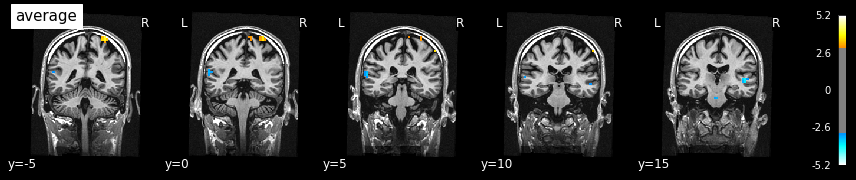

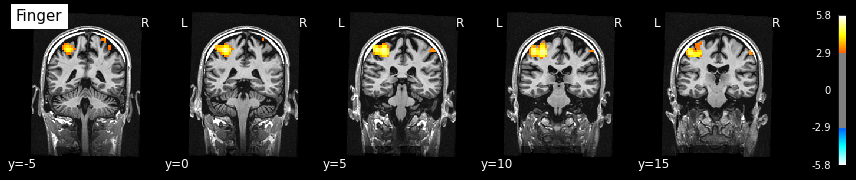

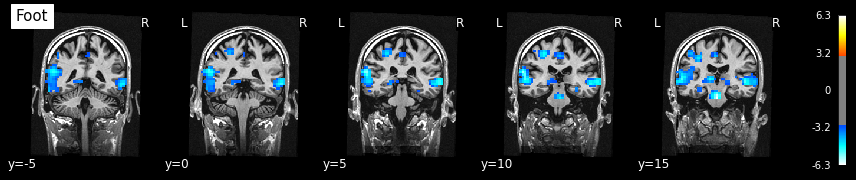

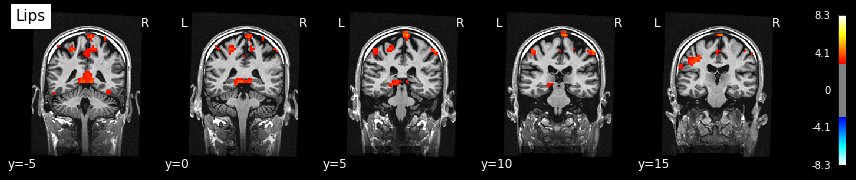

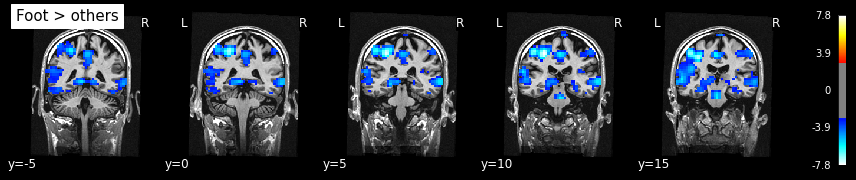

In [18]:
subject_id = '05'
 
anatimg = f'/data/ds000114/derivatives/fmriprep/sub-{subject_id}/anat/sub-{subject_id}_t1w_preproc.nii.gz'
for contrast_id in range(1, 6):
    plot_stat_map(
        f'/output/datasink/1stLevel/sub-{subject_id}/spmT_000{contrast_id}.nii', title=test_to_number[contrast_id],
        bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

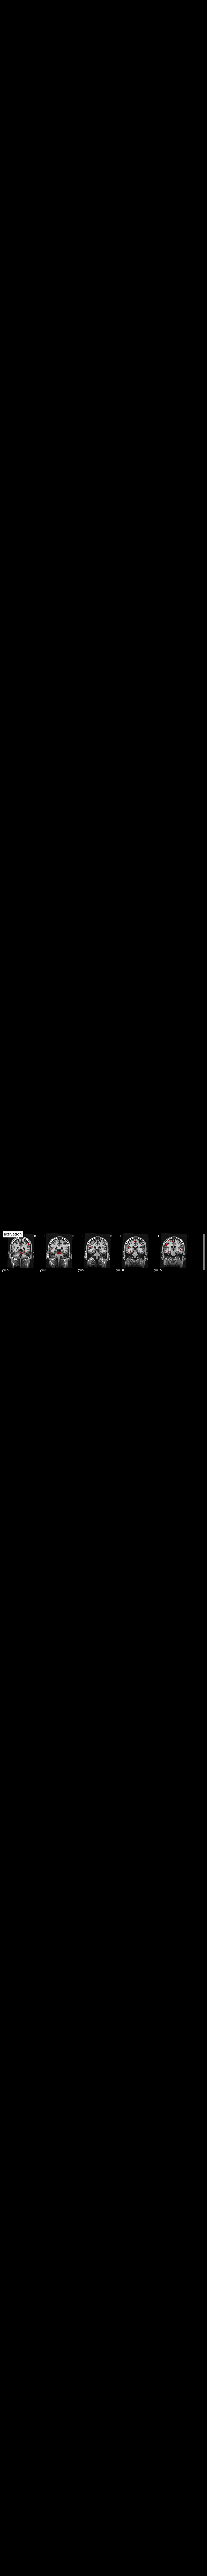

In [19]:
contrast_id = 6
subject_id = '09'

plot_stat_map(
        f'/output/datasink/1stLevel/sub-{subject_id}/spmF_000{contrast_id}.nii', title=test_to_number[contrast_id],
        bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

To add thanks to ...